# A Decoding Accuracy Analysis For Visual Selective Cells

## Project Description

In this project, we would like to look at the decoding accuracy of the visual selective cells. All the visual selective cells are pooled together. There are in total 292 visual selective cells we found using the 1x5 Anova test under the criteria p < 0.05. 

The spike rates are extracted from each trial from each cell, a 100x292 matrix is created for training and testing.

### 1. Load necessary libraries

In [6]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [7]:
from sklearn import preprocessing
from classifier import MaxCorrCoefClf
from sklearn.model_selection import KFold

### 2. Get cell data 
Read in saved cell data for all cellss and select the visual selective cells (VS) and memory selective cells (MS) based on their p values

In [8]:
np.random.seed(777)
f_all = open('data/all_cells.p', 'rb')
all_cells = pickle.load(f_all)

In [9]:
vs_cells = [cell for cell in all_cells if cell.p_vs <= 0.05]
ms_cells = [cell for cell in all_cells if cell.p_ms <= 0.05]

In [10]:
print(len(vs_cells))
print(len(ms_cells))

292
135


In [11]:
print(vs_cells[0].session_nr)
print(vs_cells[0].channel_nr)
print(vs_cells[0].cluster_id)

5
2
2


In total we have 292 VS cells and 135 MS cells

### 3. Decoding accuracy

In [39]:
def decoding_trial_processing(cells, start, end, cell_type):
    """
    This function is to extract the spike count rate from a specify time window. The output is sorted by category.
    :param cells: a list of cell objects
    :param start: the start time of the window
    :param end: the end time of the window
    :param cell_type: the type of the cell we want to extract the spike rate at
    :return x_scaled: the z scored spike count rates for each trials
    :return y: the label
    """
    x = np.empty((100, 0))
    for cell in cells:
        trials = cell.trials
        if cell_type == 'visual':
            trials.sort(key = lambda trial: trial.category)
        elif cell_type == 'memory':
            trials.sort(key = lambda trial: trial.response_recog)
        cell_spike_rates = []
        for trial in trials:
            spike_rate = trial.win_spike_rate(start, end)
            cell_spike_rates.append(spike_rate)
        cell_spike_rates = np.matrix(cell_spike_rates).T
        x = np.append(x, cell_spike_rates, axis=1)
    x_scaled = preprocessing.scale(x)
    y = np.empty((1,0))
    if cell_type == 'visual':
        for i in range(5):
            y = np.append(y, np.repeat(i+1, 20))
    elif cell_type == 'memory':
        y = np.array([trial.response_recog for trial in trials]) > 3
        print(len(y[y==1]))
        print(len(y[y==0]))
        x_scaled, y = ms_balanced_sample(x_scaled, y)

    return x_scaled, y

def get_sample_trials(x, y):
    """
    A function to generate 10 random sample from 20 trials.
    :param x: The original feature matrix (20 x 292)
    :param y: The original labels (1 x 20)
    :return sample_trials: A random sample of the feature matrix with size 10 (10 x 292)
    :return sample_labels: A random sample of the labels associated with the feature matrix
    """ 
    sample_index = np.random.choice(20, 10, replace=False)
    sample_trials = x[sample_index, :]
    sample_labels = y[sample_index]
    return sample_trials, sample_labels
    
def vs_decoding_model(x, y, iteration=50):
    """
    This function is the model to see how well the spike rate can be decoded.
    :param x: The feature matrix with all spike rates of all trials (100 x 292)
    :param y: The label associated with the feature matrix x (1 x 100)
    :param iteration: The number of iterations that the classification is done.
    :return accuracy: The accuracy score for decoding averaging all iterations and splits.
    """
    y_pred_all = np.empty((1,0))
    y_test_all = np.empty((1,0))
    for i in range(iteration):
        x_sampled = np.empty((0, x.shape[1]))
        y_sampled = np.empty((1, 0))

        for i in range(5):
            start = i*20
            end = (i+1)*20
            x_temp = x[start:end,:]
            y_temp = y[start:end]
            sample_trials, sample_labels = get_sample_trials(x_temp, y_temp)
            x_sampled = np.append(x_sampled, sample_trials, axis=0)
            y_sampled = np.append(y_sampled, sample_labels)
#         for split in range(10):
#             test_indexes = np.arange(5)*10 + split
#             train_indexes = np.delete(np.arange(50), test_indexes)
            
#             x_train = x_sampled[train_indexes, :]
#             y_train = y_sampled[train_indexes]
#             x_test = x_sampled[test_indexes, :]
#             y_test = y_sampled[test_indexes]
#             clf = MaxCorrCoefClf()
#             clf.fit(x_train.T, y_train)
#             y_pred = clf.predict(x_test.T)
#             y_pred_all = np.append(y_pred_all, y_pred)
#             y_test_all = np.append(y_test_all, y_test)
        kf = KFold(n_splits=10, shuffle=True)
        for train_index, test_index in kf.split(x_sampled):
            x_train, x_test = x_sampled[train_index], x_sampled[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = MaxCorrCoefClf()
            clf.fit(x_train.T, y_train)
            y_pred = clf.predict(x_test.T)
            y_pred_all = np.append(y_pred_all, y_pred)
            y_test_all = np.append(y_test_all, y_test)
    accuracy = np.mean(np.equal(y_pred_all, y_test_all))
    return accuracy

def decoding_simple_cv(x, y):
    y_pred_all = []
    y_test_all = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = MaxCorrCoefClf()
        clf.fit(x_train.T, y_train)
        y_pred = clf.predict(x_test.T)
        y_pred_all = np.append(y_pred_all, y_pred)
        y_test_all = np.append(y_test_all, y_test)
    return np.mean(np.equal(y_pred_all, y_test_all))

def ms_balanced_sample(x, y):
    x_new = x[y==0]
    x_old = x[y==1]
    y_new = y[y==0]
    y_old = y[y==1]
    n_old = np.sum(y==1)
    n_new = np.sum(y==0)
    if n_old <= n_new:
        indexes = np.random.choice(n_new, n_old, replace=False)
        x_new = x_new[indexes]
        y_new = y_new[indexes]
    elif n_old > n_new:
        indexes = np.random.choice(n_old, n_new, replace=False)
        x_old = x_old[indexes]
        y_old = y_old[indexes]
    x = np.vstack([x_new, x_old])
    y = np.append(y_new, y_old)
    return x, y


def decoding_over_time(cells, bin_size, step_size, cell_type, model, time_range=(0, 4000)):
    """
    The function to get the accuracy over the time of trials.
    :param vs_cells: The cells that we want to decode.
    :param bin_size: The size of the time window that we extract the spike rate from.
    :param step_size: The size that the window more forward each time.
    :param cell_type: The type of cells 'visual' or 'memory' that we are running this at. (Not finished yet)
    :param time_range: The time course that the analysis starts and ends
    :return accuracies: The accuracies accross the time course.
    :return x_plot: The x value for plotting the accuracy.
    """ 
    start = time_range[0]
    end = start + bin_size
    plot_step = bin_size/2
    accuracies = []
    x_plot = []
    while end < time_range[1]:
        x, y = decoding_trial_processing(cells, start, end, cell_type)
        accuracy = model(x, y)
        accuracies.append(accuracy)
        x_plot.append(start + plot_step)
        start = start + step_size
        end = start + bin_size
    return accuracies, x_plot

def decoding_time_matrix(cells, bin_size, step_size, time_range=(0, 4000)):
    """
    This function is used to get the accuracy matrix when we want to use the spike rate of a time frame to decode the spike 
    rate in another time frame. The output of this matrix can be plotted in a heatmap to see how the decoding accuracy is
    correlated over time.
    :param cells: The cells that carries the data.
    :param bin_size: The bin size that the spike is generated from.
    :param step_size: The size of steps the window move forward each time.
    :param time_range: The time range of the entire analysis.
    :return accuracy_matrix: The accuracy matrix stores the accuracy for all the time bins when training on their spike rates
                             and testing on the other time bins.
    """
    start = time_range[0]
    end = start + bin_size
    
    clf = MaxCorrCoefClf()
    accuracy_matrix = []
    while end < time_range[1]:
        x_train, y_train = decoding_trial_processing(cells, start, end, cell_type='visual')
        test_start = time_range[0]
        test_end = test_start + bin_size
        clf.fit(x_train.T, y_train)
        accuracies = []
        while test_end < time_range[1]:
            x_test, y_test  = decoding_trial_processing(cells, test_start, test_end, cell_type='visual')
            y_pred = clf.predict(x_test.T)
            accuracy = np.mean(np.equal(y_pred, y_test))
            accuracies.append(accuracy)
            test_start = test_start + step_size
            test_end = test_start + bin_size
        accuracy_matrix.append(accuracies)
        start = start + step_size
        end = start + bin_size
    return np.array(accuracy_matrix)
    

### 3a. 500 bin size and 50 step size

In [8]:
accuracy_matrix = decoding_time_matrix(vs_cells, 500, 50)

KeyboardInterrupt: 

In [21]:
accuracy_matrix

array([[0.97, 0.95, 0.9 , ..., 0.23, 0.25, 0.2 ],
       [0.96, 0.97, 0.93, ..., 0.23, 0.25, 0.19],
       [0.91, 0.95, 0.96, ..., 0.22, 0.26, 0.25],
       ...,
       [0.18, 0.2 , 0.19, ..., 0.97, 0.93, 0.95],
       [0.22, 0.2 , 0.21, ..., 0.95, 0.95, 0.97],
       [0.21, 0.22, 0.17, ..., 0.89, 0.93, 0.97]])

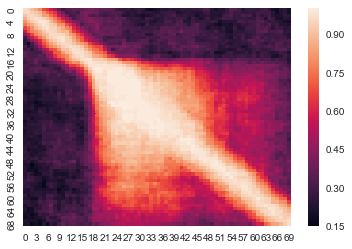

In [22]:
sns.heatmap(accuracy_matrix)

Using bin size of 500 and step size of 50 we can see the accuracy heatmap can be plotted above. The brighter the boxes, the higher the accuracy. Each box is size 50. From the heatmap we can see that starting from 800 milliseconds, we can use the classifier that trains on spike counts in a 500 time bin to accuratly decode most of the time bins after that. 

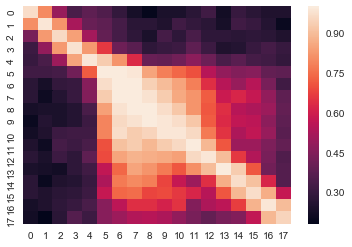

In [23]:
accuracy_bin_200 = decoding_time_matrix(vs_cells, 500, 200)
sns.heatmap(accuracy_bin_200)

Using a larger step size with 200 we can see a clearer picture of the heatmap. Showing the same result as the above.

### 3b. The VS decoding accuracy over time.

In [54]:
accuracies_vs, x_plot_vs = decoding_over_time(vs_cells, 500, 50, 'visual', vs_decoding_model)

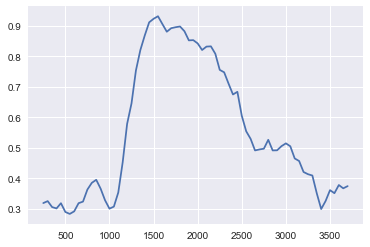

In [55]:
plt.plot(x_plot_vs, accuracies_vs)

The analysis is done on a 500 millisecion time bin and step size of 50. From the above graph we can see that before 1000 milliseconds, where the baseline period is at, the decoding accuracy is around 50% which is just random. After 1000 millisecond the decoding accuracy increases dramatically and peak above 95% at around 1600 millisecond. The decoding accuracy remains above 60% until around 2700 milliseond. 

It makes sense because the VS cells are selected using the 1x5 Anova analysis based on the spike rates extracted from the 1200 to 2700 millisecond period.

In [41]:
accuracies_test, x_plot_test = decoding_over_time(vs_cells, 500, 50, 'visual', vs_decoding_simple_cv)

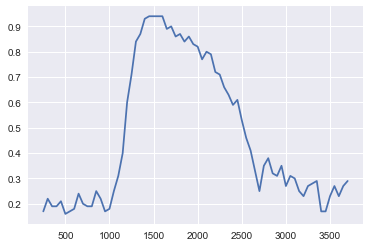

In [42]:
plt.plot(x_plot_test, accuracies_test)

In [40]:
accuracies_ms, x_plot_ms = decoding_over_time(ms_cells, 500, 50, 'memory', decoding_simple_cv)

51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49
51
49


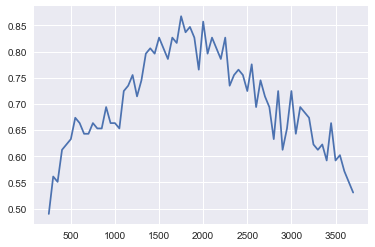

In [36]:
plt.plot(x_plot_ms, accuracies_ms)